In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "CAMTA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52204] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/1364590592/sm_segment.MacBook-Pro-de-Genereux.501.51560000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,1107,XP_011086818.1,MQSGYDINHLAREAQTRWLKPVEVFFILQNYEEHQLTHQIPQKPAS...,940,1
1,264,cra_locus_2781_iso_5,MAGSGSQNLGFRLDIKQILCEAQHRWLRPAEICEILRNYQKFHITP...,1043,1
2,2242,Solyc06g068580.1.1,MSGEEEWKQQIPPGFRFIPTDEEILQYYLFRYVTGNYILPGIIPLV...,351,0
3,672,Medtr2g008840.4,MFHITPEPHTRPPSGSLFLFDRKVLRYFRKDGHNWRKKKDGKTVKE...,1001,1
4,708,GSMUA_Achr6P10390_001,MAETRRFSLTPQLDIEQILLEAQHRWLRPAEICEILRNYQKFRIAP...,1065,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2127 non-null   int64 
 1   id          2127 non-null   object
 2   sequence    2127 non-null   object
 3   length      2127 non-null   int64 
 4   class       2127 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 83.2+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AH,AK,AL,AP,AS,AT,AY,CA,CD,CG,...,WV,WW,WY,YA,YF,YL,YQ,YR,YW,YY
0,0.001339,0.001339,0.004016,0.021419,0.008032,0.009371,0.001339,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.001339,0.000000,0.001339,0.002677,0.000000,0.002677
1,0.004604,0.000000,0.006446,0.000921,0.010129,0.004604,0.002762,0.000000,0.0,0.001842,...,0.000000,0.0,0.000000,0.002762,0.000921,0.001842,0.000000,0.003683,0.000921,0.000921
2,0.002012,0.006036,0.003018,0.004024,0.007042,0.003018,0.004024,0.002012,0.0,0.001006,...,0.000000,0.0,0.000000,0.001006,0.002012,0.002012,0.004024,0.006036,0.001006,0.003018
3,0.000000,0.000000,0.015873,0.015873,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.015873,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000
4,0.000000,0.010453,0.006969,0.000000,0.003484,0.000000,0.003484,0.003484,0.0,0.000000,...,0.003484,0.0,0.003484,0.006969,0.000000,0.003484,0.000000,0.000000,0.000000,0.003484


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 200)
X_test: (532, 200)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 23s 922ms/step - accuracy: 0.5781 - loss: 0.6926

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6431 - loss: 0.6860 - val_accuracy: 0.8803 - val_loss: 0.5974


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8438 - loss: 0.5934

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9266 - loss: 0.4983 - val_accuracy: 0.9859 - val_loss: 0.1465


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1533

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.1172 - val_accuracy: 0.9836 - val_loss: 0.0462


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0307

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.0571 - val_accuracy: 0.9906 - val_loss: 0.0377


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0110

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0290 - val_accuracy: 0.9883 - val_loss: 0.0395


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0534

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0365 - val_accuracy: 0.9930 - val_loss: 0.0284


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0144

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0322 - val_accuracy: 0.9906 - val_loss: 0.0348


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0212

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0310 - val_accuracy: 0.9930 - val_loss: 0.0264


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0135

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0233 - val_accuracy: 0.9718 - val_loss: 0.0673


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0105

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0308 - val_accuracy: 0.9930 - val_loss: 0.0268


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0221

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0140 - val_accuracy: 0.9930 - val_loss: 0.0257


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0075

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0116 - val_accuracy: 0.9906 - val_loss: 0.0258


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0846

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0248 - val_accuracy: 0.9812 - val_loss: 0.0471


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0281

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0142 - val_accuracy: 0.9906 - val_loss: 0.0260


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0017

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0069 - val_accuracy: 0.9930 - val_loss: 0.0250


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.9822e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9930 - val_loss: 0.0254



[Train Accuracy: 99.88% - Test Accuracy: 98.68%]


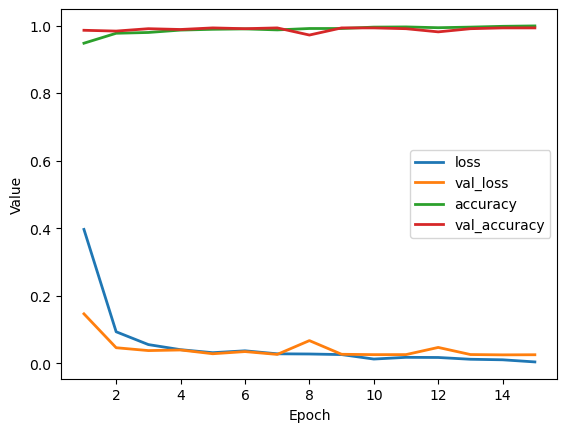

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,EAH,WAA,HIV,FQR,IVL,FRK,HWA,AHE,RIQ,LFD,...,SST,RKA,QTD,CWA,RYQ,FQL,NSC,CLL,GRH,SCT
0,0.000000,0.000000,0.000000,0.001340,0.000000,0.000000,0.000000,0.000000,0.001340,0.000000,...,0.000000,0.000000,0.0,0.0,0.00134,0.0,0.0,0.0,0.0,0.0
1,0.000922,0.000922,0.000922,0.001843,0.000000,0.000922,0.000922,0.000922,0.000000,0.000922,...,0.000922,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.001007,0.001007,0.001007,0.000000,0.001007,0.001007,0.001007,0.001007,0.002014,0.001007,...,0.001007,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003497,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 1000)
X_test: (532, 1000)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.5000 - loss: 0.6930

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6232 - loss: 0.6893   

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6433 - loss: 0.6871 - val_accuracy: 0.9648 - val_loss: 0.6114


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.6028

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.5394 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9565 - loss: 0.5226 - val_accuracy: 0.9859 - val_loss: 0.1471


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.1243

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0927 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0877 - val_accuracy: 0.9930 - val_loss: 0.0249


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0525

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0191 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0180 - val_accuracy: 0.9953 - val_loss: 0.0208


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0037

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0175 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0175 - val_accuracy: 0.9930 - val_loss: 0.0250


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0107

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0068 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9930 - val_loss: 0.0160


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.5764e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0023     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9953 - val_loss: 0.0162


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.6935e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9953 - val_loss: 0.0149


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9953 - val_loss: 0.0178


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.1441e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4877e-04 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5628e-04 - val_accuracy: 0.9930 - val_loss: 0.0116


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.5331e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9953 - val_loss: 0.0184


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0017

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9571e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4246e-04 - val_accuracy: 0.9953 - val_loss: 0.0124


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.9444e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8007e-04 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6631e-04 - val_accuracy: 0.9953 - val_loss: 0.0126


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.8266e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0540e-04 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2823e-04 - val_accuracy: 0.9930 - val_loss: 0.0111



[Train Accuracy: 100.00% - Test Accuracy: 99.25%]


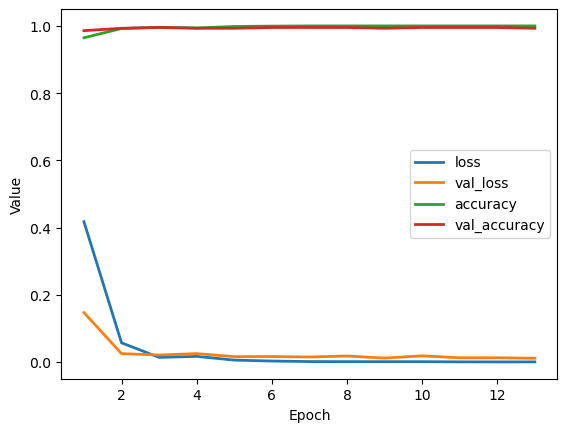

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAL,AAAR,AADA,AADL,AAFC,AAFR,AAIR,AALG,AAMK,AAPG,...,YRQA,YRRL,YRRM,YRTA,YTWA,YVTC,YWLL,YWML,YYAH,YYGR
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000923,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000923,0.000923,0.000000
2,0.0,0.002016,0.001008,0.001008,0.0,0.001008,0.0,0.000000,0.001008,0.0,...,0.0,0.0,0.001008,0.001008,0.001008,0.0,0.001008,0.000000,0.001008,0.001008
3,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.6406 - loss: 0.6930

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5292 - loss: 0.6899   

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5254 - loss: 0.6881 - val_accuracy: 0.5962 - val_loss: 0.6316


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6250 - loss: 0.6389

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8005 - loss: 0.5716 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.5630 - val_accuracy: 0.9977 - val_loss: 0.3121


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.3268

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.2524 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.2452 - val_accuracy: 0.9765 - val_loss: 0.0794


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0864

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0543 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.0532 - val_accuracy: 0.9836 - val_loss: 0.0342


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0572

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0367 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9895 - loss: 0.0355 - val_accuracy: 0.9883 - val_loss: 0.0257


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0374

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0290 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0287 - val_accuracy: 0.9977 - val_loss: 0.0190


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0189

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0265 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0254 - val_accuracy: 0.9977 - val_loss: 0.0096


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0244

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0158 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0154 - val_accuracy: 0.9977 - val_loss: 0.0114


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0028

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0075 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0080 - val_accuracy: 0.9977 - val_loss: 0.0060


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0045

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0048 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9977 - val_loss: 0.0050


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0141

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0099 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0100 - val_accuracy: 0.9977 - val_loss: 0.0046


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0020

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0057 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0061 - val_accuracy: 0.9977 - val_loss: 0.0064



[Train Accuracy: 99.76% - Test Accuracy: 99.06%]


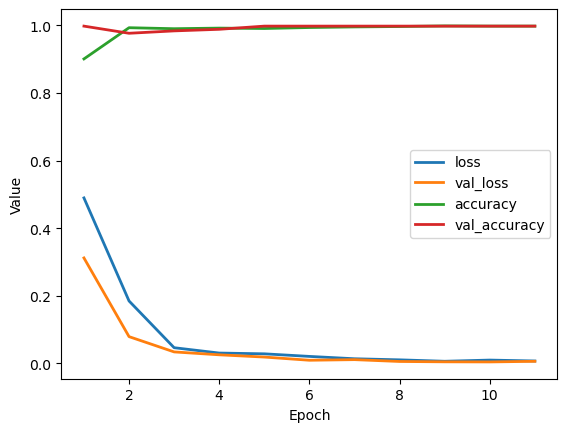

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAALG,AAARI,AADAA,AADLA,AAFCG,AAFRA,AAFRG,AALGY,AALLS,AALSI,...,YRRMK,YRRML,YRTAA,YTWAV,YVTCS,YWLLD,YWMLD,YWMLE,YYAHG,YYGRE
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000923,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000923,0.000923,0.000000
2,0.0,0.002018,0.001009,0.001009,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.001009,0.0,0.001009,0.001009,0.0,0.001009,0.0,0.000000,0.001009,0.001009
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 14s 556ms/step - accuracy: 0.7500 - loss: 0.6931

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5402 - loss: 0.6925   

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5289 - loss: 0.6910 - val_accuracy: 0.5047 - val_loss: 0.6631


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5625 - loss: 0.6563

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5982 - loss: 0.6378 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6649 - loss: 0.6156 - val_accuracy: 0.9859 - val_loss: 0.3547


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.3475

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9813 - loss: 0.3032 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.2675 - val_accuracy: 0.9812 - val_loss: 0.0710


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0523

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.0658 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.0638 - val_accuracy: 0.9812 - val_loss: 0.0748


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0888

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0507 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.0445 - val_accuracy: 0.9883 - val_loss: 0.0351


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0927

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0485 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9875 - loss: 0.0386 - val_accuracy: 0.9930 - val_loss: 0.0230


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0116

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0141 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0177 - val_accuracy: 0.9930 - val_loss: 0.0191


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0228

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - loss: 0.0184 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9951 - loss: 0.0175 - val_accuracy: 0.9930 - val_loss: 0.0157


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0967

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0365 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0278 - val_accuracy: 0.9930 - val_loss: 0.0159


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0061

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0186 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0168 - val_accuracy: 0.9906 - val_loss: 0.0301


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0264

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9935 - loss: 0.0209 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0176 - val_accuracy: 0.9930 - val_loss: 0.0154


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0235

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0109 

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0101

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0100 - val_accuracy: 0.9953 - val_loss: 0.0104


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0027

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0064 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.9930 - val_loss: 0.0122


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0027

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0065 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0080 - val_accuracy: 0.9906 - val_loss: 0.0327


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.6841e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0108     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9977 - val_loss: 0.0061


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0094

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0083 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0069 - val_accuracy: 0.9977 - val_loss: 0.0071


Epoch 17/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0030

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0068 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0067 - val_accuracy: 0.9930 - val_loss: 0.0189


Epoch 18/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0842

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0209 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0050


Epoch 19/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0155

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9923 - loss: 0.0146 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0125 - val_accuracy: 0.9906 - val_loss: 0.0350


Epoch 20/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0166

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0104 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0099


Epoch 21/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0138

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0144 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.9930 - val_loss: 0.0165


Epoch 22/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0064

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0105 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9906 - val_loss: 0.0381


Epoch 23/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0039

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0058 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0062 - val_accuracy: 0.9977 - val_loss: 0.0029


Epoch 24/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0011

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0061 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0054 - val_accuracy: 0.9977 - val_loss: 0.0047


Epoch 25/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.3288e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0037     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0020


Epoch 26/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0012

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0031


Epoch 27/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0037

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0028 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0018


Epoch 28/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0011

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0011 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0016



[Train Accuracy: 99.94% - Test Accuracy: 99.62%]


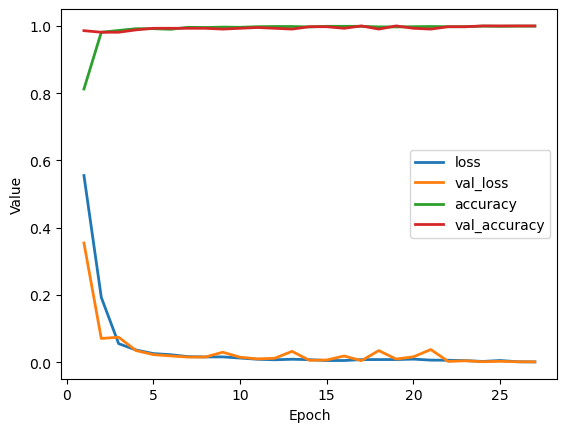

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


Report saved as Output/Reports/CAMTA/report_full_3X7EE4RM.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################